In [1]:
import sys
sys.path.append('/home/ardelalegre/SoundMapping/Analysis/Util')
sys.path.append('/home/ardelalegre/SoundMapping/Database')
from DatabaseAPI import DatabaseAPI
import numpy as np
import matplotlib.pyplot as plt
from get_time_interval_data import *
from PCA import *
from Plot import *
import pickle
from sklearn.cluster import KMeans

In [14]:
# making the D matrix
# thank you Yihan for this function

def extract_all_active_observations(interval_matrix_data, array_indices):
    
    observations = interval_matrix_data[:,1:] # exclude time column
    
    selected_obs = np.hstack([observations[:,i*3:i*3+3] for i in array_indices])#including only some arrays
    
    cleaned_data = []
    for i in range(selected_obs.shape[0]):
        if not any(np.isnan(selected_obs[i,:])):
            cleaned_data.append(selected_obs[i,:])
            
    return  np.vstack(cleaned_data)

In [13]:
chair2_20 = get_time_interval_matrix_data('Nov 20 2020 03:50PM', 'Nov 20 2020 03:54PM')
chair3_20 = get_time_interval_matrix_data('Nov 20 2020 03:55PM', 'Nov 20 2020 03:59PM')
chair4_20 = get_time_interval_matrix_data('Nov 20 2020 04:00PM', 'Nov 20 2020 04:04PM')
chair5_20 = get_time_interval_matrix_data('Nov 20 2020 04:05PM', 'Nov 20 2020 04:09PM')
chair1_20 = get_time_interval_matrix_data('Nov 20 2020 04:15PM', 'Nov 20 2020 04:19PM')
static_point_data_20 = np.vstack([chair2_20, chair3_20, chair4_20, chair5_20, chair1_20])
static_point_cdata_20 = get_cdata(static_point_data_20)
projections_20 = project_to_eigen_vectors(static_point_cdata_20, 2, EIGEN_VALUES_0819, EIGEN_VECTORS_0819)

In [17]:
# pickle dump all exp data

pickle.dump(chair2_20, open('chair2_20.p', 'wb'))
pickle.dump(chair3_20, open('chair3_20.p', 'wb'))
pickle.dump(chair4_20, open('chair4_20.p', 'wb'))
pickle.dump(chair5_20, open('chair5_20.p', 'wb'))
pickle.dump(chair1_20, open('chair1_20.p', 'wb'))

# download the data onto local
# download this notebook onto google drive and run it
# run jupyter on google drive and see how much of it runs

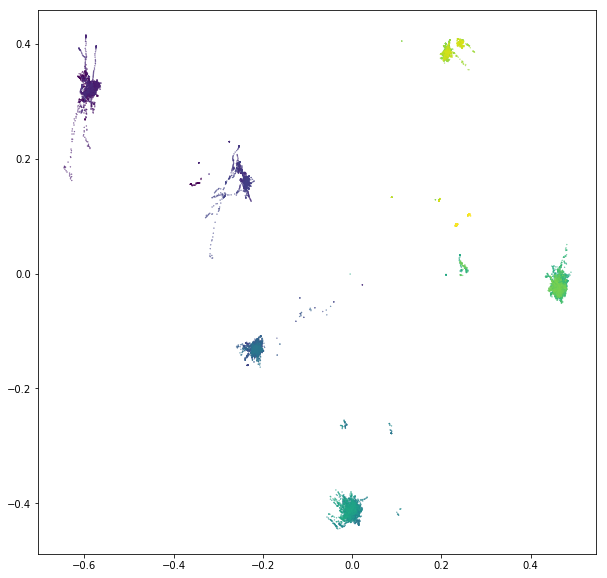

In [4]:
plt.figure(figsize=(10,10))
plt.scatter(projections_20[:,0], projections_20[:,1], c = np.arange(projections_20.shape[0]), s = 0.1);

In our recreation of the experiment, we see that there are multiple clusters sometimes, so this is a recurring problem.

#### Which arrays are active?

In [5]:
# extracting cdata from data (ignoring time index)

static_point_cdata_20 = static_point_data_20[:,1:]


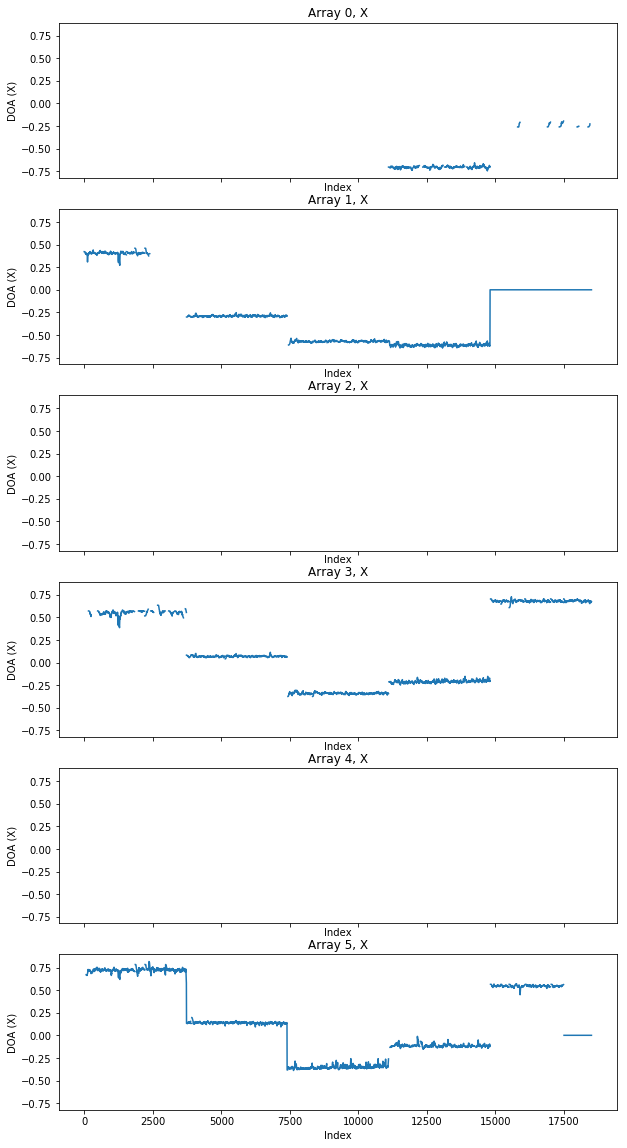

In [6]:
fig, axs = plt.subplots(6,1, sharex = True, sharey = True, figsize = [10,20])
for i in range(6):
    axs[i].plot(static_point_cdata_20[:,3*i])
    axs[i].set_title("Array {0}, X".format(i))
    axs[i].set_ylabel("DOA (X)")
    axs[i].set_xlabel("Index")

We observe that Array 2 and Array 4 have only nan values. We will create a observation matrix which doesn't have values from these two arrays.

### Measurements in physical space in meters (Determining R)

#### Naming convention:

Peter's chair: Chair 1  
Chaitanya's fall chair: Chair 2  
Corner chair: Chair 3  
Chair opp Peter close to door: Chair 4  
Chair opp Peter not close to door: Chair 5

#### Origin:

Corner closest to corner chair.

X direction is line that includes the door.  

Y axis is adjacent to Chaitanya's fall table.

Measurements with laser pointer:

Chair 4:  
X = 2.598 m  
Y = 1.567 m

Chair 5:  
X = 3.544 m  
Y = 1.523 m

Chair 3:  
X = 0.450 m  
Y = 0.791 m

Chair 2:  
X = 1.266 m  
Y = 2.685 m

Chair 1:  
X = 3.040 m  
Y = 3.120 m

Width of room (X direction) = 4.305 m  
Length of room (Y direction) = 3.841 m

Ordering all $L=\sum_{k=1}^K L_k$ observations into a room location matrix /
\begin{equation}
{\bf R} =[{\bf r_1} {\bf i}^T_{L_1}\dots {\bf r_K} {\bf i}^T_{L_K}] \in \mathbb{R}^{N\times L}
\end{equation}
where ${\bf i}_{L}$ is a vector of length $L$ with all ones.
Similarly ${\bf D}=[{\bf D}_1\, \dots {\bf D}_K]\in \mathbb{R}^{M\times L}$


In [7]:
five_minute_1 = extract_all_active_observations(chair2_20, [1,3,5])
five_minute_2 = extract_all_active_observations(chair3_20, [1,3,5])
five_minute_3 = extract_all_active_observations(chair4_20, [1,3,5])
five_minute_4 = extract_all_active_observations(chair5_20, [1,3,5])

L_1 = five_minute_1.shape[0]
L_2 = five_minute_2.shape[0]
L_3 = five_minute_3.shape[0]
L_4 = five_minute_4.shape[0]

all_L = [L_1, L_2, L_3, L_4]
all_observations_len = L_1 + L_2 + L_3 + L_4

# in order to get D

D = np.hstack([five_minute_1.T, five_minute_2.T, five_minute_3.T, five_minute_4.T])

# creating R

R_1 = np.zeros((2,all_L[0]))+np.reshape(np.array([1.266, 2.685]), [2,1])

R_2 = np.zeros((2,all_L[1]))+np.reshape(np.array([0.450, 0.791]), [2,1])

R_3 = np.zeros((2,all_L[2]))+np.reshape(np.array([2.598, 1.567]), [2,1])

R_4 = np.zeros((2,all_L[3]))+np.reshape(np.array([3.544, 1.523]), [2,1])

R = np.hstack([R_1, R_2, R_3, R_4])

\begin{eqnarray}
{\bf r}_0={\sf E}[{\bf r_k}]
\\
{\bf B}=[{\bf R} -{\bf r_0} {\bf i}^T_{L}]{\bf D}^+
\end{eqnarray}
$^+$ denotes the Moore-Penrose pseudo-inverse.

In [8]:
# Here our assumption of L_1 = L_2 = ... = L_k does not hold, so we take mean of R to get r_0

r_0 = np.reshape(np.mean(R, axis = 1), [2,1])
D_plus = np.linalg.pinv(D) # calculating moore penrose inverse
all_observations_len = D.shape[1] # desired number of columns in  r_0 @ i^T_L

r_0_long = r_0 + np.zeros([2,all_observations_len])

B = (R - r_0_long) @ D_plus # obtaining linear transformation matrix


### Plotting chair locations

In [9]:
r = r_0 + (B@D)

In [10]:
positions = {'chair1':[3.040, 3.120], 'chair2':[1.266,2.685], 'chair3':[0.450,0.791],'chair4':[2.598, 1.567],'chair5':[3.544,1.523]}


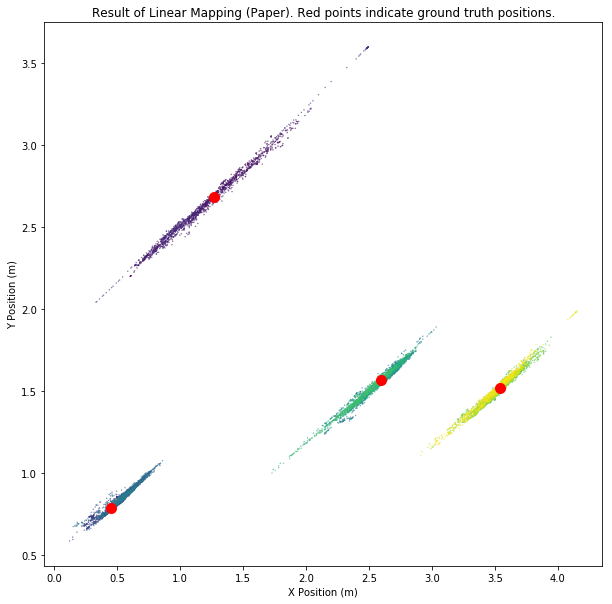

In [12]:
fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(111)
ax.scatter(r[0,:], r[1,:], c = np.arange(r.shape[1]), s = 0.1);
for i in positions:
    if(i == 'chair1'):
        continue
    ax.scatter(positions[i][0],positions[i][1], c = 'r', s = 100)
ax.set_title("Result of Linear Mapping (Paper). Red points indicate ground truth positions.")
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)");